In [1]:

import quimb as qu
import quimb.tensor as qtn

In [2]:
# contengra is a library for optimizing tensor network contractions
# tensor network contractions are done by repeatedly contracting pairs of tensors
import cotengra as ctg
# ReusableHyperOptimizer is a subclass of HyperOptimizer which is used to optimize a single
#  path repeatedly. This is useful for optimizing paths which are reused many times, such as in a DMRG sweep.
# the arguments are as follows: methods, reconf_opts, max_repeats, max_time, parallel, directory
# methods: list of methods to use for optimization
# reconf_opts: dictionary of options to pass to the reconfigurer
# max_repeats: maximum number of times to repeat the optimization
# max_time: maximum time to spend optimizing
# parallel: whether to use parallel optimization
# directory: whether to use a directory to cache paths
opt = ctg.ReusableHyperOptimizer(
    methods=['greedy'],
    reconf_opts={}, 
    max_repeats=32,
    max_time="rate:1e6",
    parallel=True,
    # use the following for persistently cached paths
    # directory=True,
)

/home/iisers/.local/lib/python3.8/site-packages/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


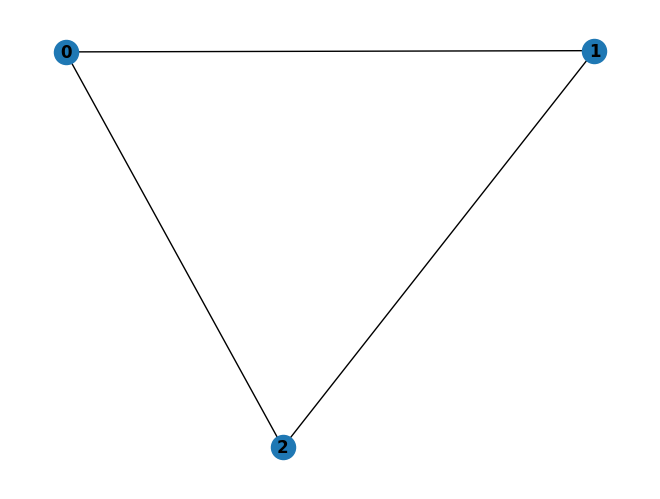

In [3]:
import networkx as nx
# create a 4 regular graph with 5 nodes

n = 3
seed = 666
edges = {(0, 1):48, (0, 2):91, (1, 2): 63}
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(edges.keys())
# add weights to the edges
nx.set_edge_attributes(G, edges, 'weight')
nx.draw(G, with_labels=True, font_weight='bold')
terms = {(0, 1):48, (0, 2):91, (1, 2): 63}

In [19]:
edges = []
for j in range(9):
    for i in range(9):
        if i < j:
            edges.append((i,j))
print(edges)

weights = [606.5,606.5,606.5,606.5,15.75,15.75,15.75,606.5,15.75,606.5,15.75,15.75,606.5,606.5,606.5,606.5,22.75,22.75,606.5,12,12,22.75,606.5,22.75,12,606.5,12,606.5,22.75,22.75,606.5,12,12,606.5,606.5,606.5]

graph = dict(zip(edges,weights))
print(graph)

[(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (3, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8)]
{(0, 1): 606.5, (0, 2): 606.5, (1, 2): 606.5, (0, 3): 606.5, (1, 3): 15.75, (2, 3): 15.75, (0, 4): 15.75, (1, 4): 606.5, (2, 4): 15.75, (3, 4): 606.5, (0, 5): 15.75, (1, 5): 15.75, (2, 5): 606.5, (3, 5): 606.5, (4, 5): 606.5, (0, 6): 606.5, (1, 6): 22.75, (2, 6): 22.75, (3, 6): 606.5, (4, 6): 12, (5, 6): 12, (0, 7): 22.75, (1, 7): 606.5, (2, 7): 22.75, (3, 7): 12, (4, 7): 606.5, (5, 7): 12, (6, 7): 606.5, (0, 8): 22.75, (1, 8): 22.75, (2, 8): 606.5, (3, 8): 12, (4, 8): 12, (5, 8): 606.5, (6, 8): 606.5, (7, 8): 606.5}


In [20]:
lattice_cite = [i for i in range(9)]
field_str = [-1290,-1290,-1290,-1268.5,-1268.5,-1268.5,-1282.5,-1282.5,-1282.5]
diag_terms = dict(zip(lattice_cite,field_str))

In [21]:
def circuit_qaoa(
    terms,
    diagonal_terms,
    depth,
    gammas,
    betas,
    **circuit_opts,
):
    r"""Generate the QAOA circuit for weighted graph described by ``terms``.

    .. math::

        |{\bar{\gamma}, \bar{\beta}}\rangle = U_B (\beta _p)
        U_C (\gamma _p) \cdots U_B (\beta _1) U_C (\gamma _1) |{+}\rangle

    with

    .. math::

        U_C (\gamma) = e^{-i \gamma \mathcal{C}} = \prod \limits_{i, j
        \in E(G)} e^{-i \gamma w_{i j} Z_i Z_j}

    and

    .. math::

        U_B (\beta) = \prod \limits_{i \in G} e^{-i \beta X_i}


    Parameters
    ----------
    terms : dict[tuple[int], float]
        The mapping of integer pair keys ``(i, j)`` to the edge weight values,
        ``wij``. The integers should be a contiguous range enumerated from
        zero, with the total number of qubits being inferred from this.
    diagonal_terms: dict[tuple[int], float]
        the mapping of diagonal terrms (i,i) to the weight values or external field values 
    depth : int
        The number of layers of gates to apply, ``p`` above.
    gammas : iterable of float
        The interaction angles for each layer.
    betas : iterable of float
        The rotation angles for each layer.
    circuit_opts
        Supplied to :class:`~quimb.tensor.circuit.Circuit`. Note
        ``gate_opts={'contract': False}`` is set by default (it can be
        overridden) since the RZZ gate, even though it has a rank-2
        decomposition, is also diagonal.
    """
    #from .circuit import Circuit


    circuit_opts.setdefault('gate_opts', {})
    circuit_opts['gate_opts'].setdefault('contract', False)


    n = 9
    #max(itertools.chain.from_iterable(terms)) + 1


    gates = []


    # layer of hadamards to get into plus state
    for i in range(n):
        gates.append((0, 'h', i))


    for d in range(depth):
        for (i, j), wij in terms.items():
            gates.append((d, 'rzz', wij * gammas[d], i, j))
        
        for i, h_i in diagonal_terms.items():
            gates.append((d, 'rz',h_i* gammas[d],i))


        for i in range(n):
            gates.append((d, 'rx', -betas[d] * 2, i))


    circ = qtn.Circuit(n, **circuit_opts)
    circ.apply_gates(gates)


    return circ

In [4]:
p = 4
gammas = qu.randn(p)
betas = qu.randn(p)
circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)

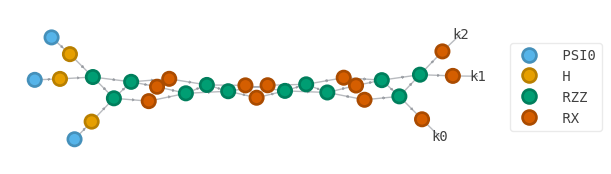

In [5]:
circ_ex.psi.draw(color=['PSI0', 'H', 'RZZ', 'RX'],show_inds=True)


In [24]:
def energy(x):
    p = len(x) // 2
    gammas = x[:p]
    betas = x[p:]
    circ = circuit_qaoa(graph,diag_terms, p, gammas, betas)
    ens = [
        circ.local_expectation(G, where, optimize=opt)
        for where, G in terms.items()
    ]
    return sum(ens).real

In [6]:
import tqdm
# qu.pauli returns a tensor representing the pauli matrix corresponding to the argument
# here we are using it to get the tensor representation of the pauli Z matrix
# ZZ is the tensor product of two Z matrices; 
ZZ = qu.pauli('Z') & qu.pauli('Z')
# local_expectation_rehearse returns the expectation value of the local operator
#local operator is the operator which acts on a single qubit
# the arguments are the local operator, the edge on which the local operator acts, and the optimization method
# expectation value of the operator is the sum of the product of the operator and the state over all possible states
# physically it meanse the average value of the operator 
local_exp_rehs = [
    circ_ex.local_expectation_rehearse(weight * ZZ, edge, optimize=opt)
    for edge, weight in tqdm.tqdm(list(terms.items()))
]

100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


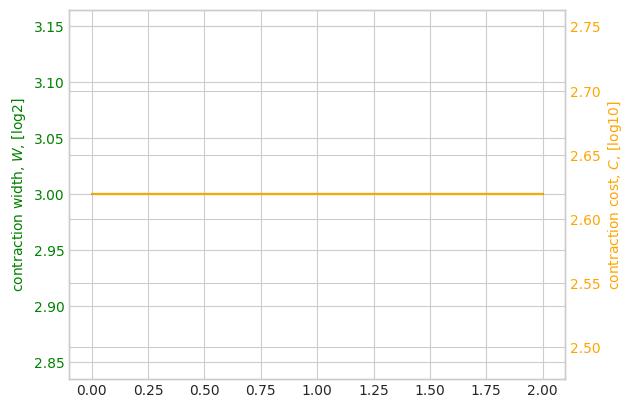

In [7]:
import matplotlib.pyplot as plt
# contraction 
with plt.style.context(plt.style.available[26]):
    fig, ax1 = plt.subplots() # instantiate a figure and an axes
    ax1.plot([rehs['W'] for rehs in local_exp_rehs], color='green') # contraction width is the number of tensors in the contraction path
    ax1.set_ylabel('contraction width, $W$, [log2]', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
    ax2.plot([rehs['C'] for rehs in local_exp_rehs], color='orange') # contraction cost is the number of floating point operations in the contraction path
    ax2.set_ylabel('contraction cost, $C$, [log10]', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

In [8]:
def energy(x):
    p = len(x) // 2
    gammas = x[:p]
    betas = x[p:]
    circ = qtn.circ_qaoa(terms, p, gammas, betas)

    ZZ = qu.pauli('Z') & qu.pauli('Z')

    ens = [
        circ.local_expectation(weight * ZZ, edge, optimize=opt)
        for edge, weight in terms.items()
    ]
    
    return sum(ens).real

In [9]:
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective

In [10]:
eps = 1e-6
bounds = (
    [(0.0        + eps, qu.pi / 2 - eps)] * p + 
    [(-qu.pi / 4 + eps, qu.pi / 4 - eps)] * p
)

bopt = Optimizer(bounds)

In [11]:
for i in tqdm.trange(100):
    x = bopt.ask()
    res = bopt.tell(x, energy(x))

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


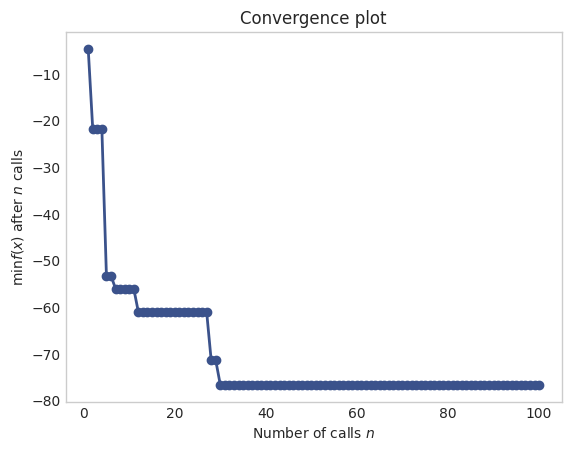

In [13]:
with plt.style.context(plt.style.available[26]):
    plot_convergence(res);

In [14]:
with plt.style.context(plt.style.available[26]):
    plot_objective(
        res, 
        cmap='RdYlBu_r',
        dimensions=[f'$\\gamma_{i}$' for i in range(p)] + [f'$\\beta_{i}$' for i in range(p)],
    );